In [1]:
from read_mnist import read_images, read_labels
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_dataset(name):
    def featurize(image):
        return image.astype(float) / 255.0
    images = np.array([featurize(image) for image in read_images(name + '-images-idx3-ubyte')])
    labels = np.array([label for label in read_labels(name + '-labels-idx1-ubyte')])
    return images, labels

In [3]:
import os
test_in, test_out = load_dataset('../data/t10k')
train_in, train_out = load_dataset('../data/train')

(28, 28)


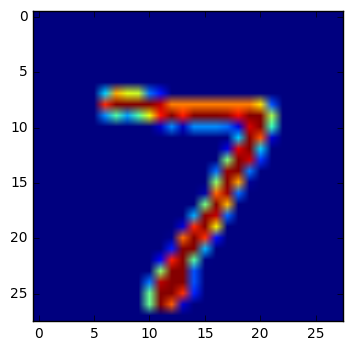

In [4]:
%matplotlib inline
plt.imshow(test_in[0])
print test_in[0].shape

In [5]:
dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')        

def weight_var(shape, stddev=0.1, weight_decay=0, name=None):
    initial = tf.truncated_normal(shape, stddev=stddev)
    v = tf.Variable(initial, name=name)
    if weight_decay > 0:
        l2 = tf.nn.l2_loss(v) * weight_decay
        tf.add_to_collection('losses', l2)
    return v

def create_fc(input, out_size):
    # input_dropped = tf.nn.dropout(input, dropout_keep_prob)
    in_size = input.get_shape()[-1].value
    w = weight_var([in_size, out_size], weight_decay=0.004, name='w')
    b = weight_var([out_size], weight_decay=0.004, name='b')
    x = tf.matmul(input, w)
    return tf.nn.relu(x + b)

def create_conv(input, out_channels, patch_size=5, stride=1, batch_norm=False, dropout=False):
    in_channels = input.get_shape()[-1].value
    w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w')
    b = weight_var([out_channels], stddev=0, name='b')
    conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
    if batch_norm: conv = create_batch_norm(conv)
    activation = tf.nn.relu(conv + b)
    if dropout: activation = create_dropout(activation)
    return activation

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_batch_norm(inputs):
    return batch_norm(inputs, is_training=TRAIN)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

In [6]:
def feedforward(images):
    images = tf.reshape(images, [-1, 28, 28, 1])
    with tf.variable_scope('conv1'):
        conv1 = create_conv(images, 32)
    pool1 = create_max_pool(conv1)
    with tf.variable_scope('conv2'):
        conv2 = create_conv(pool1, 64)
    pool2 = create_max_pool(conv2) # now 7x7x64
    conv_out = tf.reshape(pool2, [-1, 7*7*pool2.get_shape()[-1].value])
    with tf.variable_scope('fc1'):
        fc1 = create_fc(conv_out, 1024)
    fc1 = create_dropout(fc1)
    with tf.variable_scope('fc2'):
        logits = create_fc(fc1, 10)
    return logits

In [7]:
images = tf.placeholder(tf.float32, [None, 28, 28])
labels = tf.placeholder(tf.int64, [None])
logits = feedforward(images)
probabilities = tf.nn.softmax(logits)
classifications = tf.argmax(probabilities, axis=1)

In [8]:
for v in tf.global_variables():
    print v.name

print 

conv1/w:0
conv1/b:0
conv2/w:0
conv2/b:0
fc1/w:0
fc1/b:0
fc2/w:0
fc2/b:0



In [9]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels))
optimizer = tf.train.AdamOptimizer(0.0001)
global_step = tf.contrib.framework.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)
accuracy = tf.reduce_mean(tf.cast(tf.equal(classifications, labels), tf.float32))

In [10]:
save_path = 'models/mnist-11'
if not os.path.exists(save_path):
    os.mkdir(save_path)

session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
    
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(save_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(session, ckpt.model_checkpoint_path)
    print 'Restored from checkpoint', ckpt.model_checkpoint_path
else:
    print 'Did not restore from checkpoint'

Did not restore from checkpoint


In [11]:
def random_batch(inputs, outputs, count=50):
    indices = np.random.randint(0, len(inputs)-1, count)
    return inputs.take(indices, axis=0), outputs.take(indices, axis=0)

In [ ]:
write_out = False
if write_out:
    allowed_names = []
    for x in ['conv1', 'fc1', 'conv2', 'fc2']:
        for y in ['/w:0', '/b:0']:
            allowed_names.append(x+y)
    for variable in tf.global_variables():
        print variable.name
        if variable.name in allowed_names:
            weight_list = session.run(variable).tolist()
            thefile = open('models/mnist-weights/{0}.data'.format(variable.name.replace('/', '_').replace(':0', '')), 'w')
            thefile.write(str(weight_list))
            thefile.close()

In [ ]:
for i in xrange(1000000):
    ti, tl = random_batch(train_in, train_out, count=128)
    feed_dict = {dropout_keep_prob: 0.5, labels: tl, images: ti}
    loss_, global_step_, _ = session.run([loss, global_step, train_step], feed_dict=feed_dict)
    # print 'loss:', loss_
    if global_step_ % 100 == 0:
        ti, tl = random_batch(test_in, test_out, count=512)
        feed_dict = {dropout_keep_prob: 1, labels: tl, images: ti}
        accuracy_ = session.run(accuracy, feed_dict=feed_dict)
        print 'Accuracy:', accuracy_, 'at step', global_step_
        saver.save(session, save_path + '/model.ckpt', global_step=global_step_)


Accuracy: 0.482422 at step 100
Accuracy: 0.568359 at step 200
Accuracy: 0.835938 at step 300
Accuracy: 0.939453 at step 400
Accuracy: 0.958984 at step 500
Accuracy: 0.957031 at step 600
Accuracy: 0.976562 at step 700
Accuracy: 0.976562 at step 800
Accuracy: 0.964844 at step 900
Accuracy: 0.978516 at step 1000
Accuracy: 0.988281 at step 1100
Accuracy: 0.976562 at step 1200
Accuracy: 0.976562 at step 1300
Accuracy: 0.990234 at step 1400
Accuracy: 0.988281 at step 1500
Accuracy: 0.984375 at step 1600
Accuracy: 0.984375 at step 1700
Accuracy: 0.990234 at step 1800
